<a href="https://colab.research.google.com/github/iammuhammad41/Nuclei-and-Tissue-Segmentation/blob/main/deepUNet-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
from glob import glob
import numpy as np
from sklearn.model_selection import KFold,StratifiedKFold
import time
import cv2
import keras
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import adam_v2
from albumentations import *
from keras import backend as K
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import skimage.morphology
from skimage.io import imsave
from skimage.morphology import remove_small_objects
import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

opts = {}
opts['number_of_channel'] = 3
opts['treshold'] = 0.5
opts['epoch_num'] = 100
opts['quick_run'] = 1
opts['batch_size'] = 16
opts['random_seed_num'] = 19
opts['k_fold'] = 5
opts['save_val_results'] = 1
opts['init_LR'] = 0.001
opts['LR_decay_factor'] = 0.5
opts['LR_drop_after_nth_epoch'] = 20
opts['crop_size'] = 512

opts['result_save_path'] ='/content/input/prediction_image/'
opts['model_save_path'] ='/content/input/output_model/'


In [ ]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush()

In [ ]:
base_path = '../input/nuinsseg/'
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['mouse muscle_tibia',
 'mouse liver',
 'human liver',
 'human umbilical cord',
 'mouse thymus',
 'human lung',
 'human epiglottis',
 'human spleen',
 'mouse fat (white and brown)_subscapula',
 'human cardia',
 'human salivory gland',
 'human melanoma',
 'human kidney',
 'human pylorus',
 'human jejunum',
 'human testis',
 'mouse spleen',
 'human tongue',
 'human cerebellum',
 'human oesophagus',
 'mouse heart',
 'human pancreas',
 'human brain',
 'human muscle',
 'human placenta',
 'human bladder',
 'mouse kidney',
 'human tonsile',
 'human rectum',
 'mouse femur',
 'human peritoneum']

In [ ]:
# input and outpu paths
img_path = glob('{}*{}'.format('../input/nuinsseg/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/label masks modify/', 'tif'))
vague_mask_path =  glob('{}*{}'.format('../input/nuinsseg/*/vague areas/mask binary/', 'png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('/content/input/prediction_image/'):
    os.makedirs('/content/input/prediction_image/')
if not os.path.exists('/content/input/output_model/'):
    os.makedirs('/content/inputoutput_model/')
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')

In [ ]:
#random check
rand_num = np.random.randint(len(img_path))
print('image path: {}\n'.format(img_path[rand_num]),
      'binary mask path: {}\n'.format(binary_mask_path[rand_num]),
      'distance mask path: {}\n'.format(distance_mask_path[rand_num]),
      'label mask path: {}\n'.format(label_mask_path[rand_num]))


image path: ../input/nuinsseg/human melanoma/tissue images/human_melanoma_07.png
 binary mask path: ../input/nuinsseg/human melanoma/mask binary/human_melanoma_07.png
 distance mask path: ../input/nuinsseg/human melanoma/distance maps/human_melanoma_07.png
 label mask path: ../input/nuinsseg/human melanoma/label masks modify/human_melanoma_07.tif



In [ ]:
# define loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Combination of Dice and binary cross entophy loss function that is used in this baseline segmentation
def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
# learning rate scheduler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, epochs_drop=1000):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))

    return LearningRateScheduler(schedule, verbose = 1)

In [ ]:
# U-net models

def shallow_unet( IMG_CHANNELS, LearnRate):
    inputs = Input((None, None, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (p2)
    c3 = Dropout(0.1) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (p3)
    c4 = Dropout(0.1) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (p4)
    c5 = Dropout(0.1) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (u6)
    c6 = Dropout(0.1) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (u7)
    c7 = Dropout(0.1) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9) # for binary

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = adam_v2.Adam(learning_rate= LearnRate), loss= bce_dice_loss , metrics=[dice_coef])
    #model.summary()
    return model

def deep_unet(IMG_CHANNELS, LearnRate):
    # Build U-Net model
    inputs = Input((None, None, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.1) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.1) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


    c4_new = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c4_new = Dropout(0.1) (c4_new)
    c4_new = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4_new)
    p4_new = MaxPooling2D(pool_size=(2, 2)) (c4_new)

    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4_new)
    c5 = Dropout(0.1) (c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)


    u6_new = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
    u6_new = concatenate([u6_new, c4_new])
    c6_new = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6_new)
    c6_new = Dropout(0.1) (c6_new)
    c6_new = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6_new)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6_new)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.1) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.1) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model_deep = Model(inputs=[inputs], outputs=[outputs])
    model_deep.compile(optimizer = adam_v2.Adam(learning_rate=LearnRate), loss= bce_dice_loss , metrics=[ dice_coef])
    #model_deep.summary()
    return model_deep

In [ ]:
# augmentation function
def albumentation_aug(p=1.0, crop_size_row = 448, crop_size_col = 448 ):
    return Compose([
        RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1),
        CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, brightness_by_max=True, p=0.4),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.1),
        HorizontalFlip(always_apply=False, p=0.5),
        VerticalFlip(always_apply=False, p=0.5),
        RandomRotate90(always_apply=False, p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1,
                         border_mode=4, always_apply=False, p=0.1),

    ], p=p)


In [ ]:
# evaluation index (from: https://github.com/vqdang/hover_net/blob/master/src/metrics/stats_utils.py)


def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    #print(len(pred_id_list))
    if len(pred_id_list) == 1:
        return 0

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    #print(aji_score)
    return aji_score

def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing.
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.

    Fast computation requires instance IDs are in contiguous orderding
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]:
                      pairing information to perform measurement

    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    if len(pred_id_list) == 1:
        return [0, 0, 0], [0,0, 0, 0]

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]


    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]



def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    dice_score = 2.0 * np.sum(inter) / (np.sum(denom) + 0.0001)
    if np.sum(inter)==0 and np.sum(denom)==0:
        dice_score = 1 # to handel cases without any nuclei
    #print(dice_score)
    return dice_score

def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3]
    not [0, 2, 4, 6]. The ordering of instances (which one comes first)
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred



def pair_coordinates(setA, setB, radius):
    """Use the Munkres or Kuhn-Munkres algorithm to find the most optimal
    unique pairing (largest possible match) when pairing points in set B
    against points in set A, using distance as cost function.
    Args:
        setA, setB: np.array (float32) of size Nx2 contains the of XY coordinate
                    of N different points
        radius: valid area around a point in setA to consider
                a given coordinate in setB a candidate for match
    Return:
        pairing: pairing is an array of indices
        where point at index pairing[0] in set A paired with point
        in set B at index pairing[1]
        unparedA, unpairedB: remaining poitn in set A and set B unpaired
    """
    # * Euclidean distance as the cost matrix
    pair_distance = scipy.spatial.distance.cdist(setA, setB, metric='euclidean')

    # * Munkres pairing with scipy library
    # the algorithm return (row indices, matched column indices)
    # if there is multiple same cost in a row, index of first occurence
    # is return, thus the unique pairing is ensured
    indicesA, paired_indicesB = linear_sum_assignment(pair_distance)

    # extract the paired cost and remove instances
    # outside of designated radius
    pair_cost = pair_distance[indicesA, paired_indicesB]

    pairedA = indicesA[pair_cost <= radius]
    pairedB = paired_indicesB[pair_cost <= radius]

    pairing = np.concatenate([pairedA[:,None], pairedB[:,None]], axis=-1)
    unpairedA = np.delete(np.arange(setA.shape[0]), pairedA)
    unpairedB = np.delete(np.arange(setB.shape[0]), pairedB)
    return pairing, unpairedA, unpairedB


In [ ]:
# data generator related functions
def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')

def chunker(seq, seq2, size):
    return ([seq[pos:pos + size], seq2[pos:pos + size]] for pos in range(0, len(seq), size))

def data_gen(list_files, list_files2, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    crop_size_row = size_row
    crop_size_col = size_col
    aug = albumentation_aug(p, crop_size_row, crop_size_col)

    while True:
        for batch in chunker(list_files,list_files2, batch_size):
            X = []
            Y = []

            for count in range(len(batch[0])):
                x = cv2.imread(batch[0][count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x_mask = cv2.imread(batch[1][count], cv2.IMREAD_GRAYSCALE)

                x_mask_temp = np.zeros((x_mask.shape[0], x_mask.shape[1]))
                x_mask_temp[x_mask == 255] = 1


                if distance_unet_flag == False:
                    if augment:
                        augmented = aug(image= x, mask= x_mask_temp)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask_temp = augmented['mask']
                        x = x/255
                    else:
                        x = x/255
                    X.append(x)
                    Y.append(x_mask_temp)
                else:
                    if augment:
                        augmented = aug(image=x, mask=x_mask)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask = augmented['mask']
                        x = x/255
                    else:
                        x = x/255

                    X.append(x)
                    x_mask = (x_mask - np.min(x_mask))/ (np.max(x_mask) - np.min(x_mask) + 0.0000001)
                    Y.append(x_mask)

                del x_mask
                del x_mask_temp
                del x
            Y = np.expand_dims(np.array(Y), axis=3)
            Y = np.array(Y)
            yield np.array(X), np.array(Y)

In [ ]:
# main training loop (for all k fold cross-validation)
kf = KFold(n_splits= opts['k_fold'],random_state= opts['random_seed_num'],shuffle=True)
kf.get_n_splits(img_path)

start_time = time.time()
dice_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])


dice_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

dice_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

dice_mean = []
aji_mean = []
pq_mean = []

dice_watershed_mean = []
aji_watershed_mean = []
pq_watershed_mean = []

dice_watershed_wovague_mean = []
aji_watershed_wovague_mean = []
pq_watershed_wovague_mean = []

current_fold = 1

for idx, [train_index,  test_index] in enumerate(kf.split(img_path)):
    shuffle(train_index)
    shuffle(test_index)

    train_img   = [img_path[name] for name in train_index]
    train_mask  = [binary_mask_path[name] for name in train_index]
    train_dis   = [distance_mask_path[name] for name in train_index]
    train_label = [label_mask_path[name] for name in train_index]

    test_img   = [img_path[name] for name in test_index]
    test_mask  = [binary_mask_path[name] for name in test_index]
    test_dis   = [distance_mask_path[name] for name in test_index]
    test_label = [label_mask_path[name] for name in test_index]
    test_vague = [vague_mask_path[name] for name in test_index]

    #creating validation set
    validation_set_img = []
    validation_set_label = []
    #validation_DIS = []
    validation_set_vague = []
    for counter in range(len(test_img)):
        val_img = cv2.imread(test_img[counter])
        val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
        val_img = val_img/255
        val_label = cv2.imread(test_label[counter], -1) # cv2.IMREAD_UNCHANGED:
        #It specifies to load an image as such including alpha channel.
        #Alternatively, we can pass integer value -1 for this flag.
        val_vague = cv2.imread(test_vague[counter], -1)

        validation_set_img.append(val_img)
        validation_set_label.append(val_label)
        validation_set_vague.append(val_vague)

    validation_set_img = np.array(validation_set_img)
    validation_set_label = np.array(validation_set_label)
    validation_set_vague = np.array(validation_set_vague)

    model_path = opts['model_save_path'] + 'unet_{}.h5'.format(current_fold)
    logger = CSVLogger(opts['model_save_path']+ 'unet_{}.log'.format(current_fold))
    LR_drop = step_decay_schedule(initial_lr= opts['init_LR'],
                              decay_factor = opts['LR_decay_factor'],
                              epochs_drop = opts['LR_drop_after_nth_epoch'])
    model_raw = deep_unet(opts['number_of_channel'], opts['init_LR'])
    checkpoint = ModelCheckpoint(model_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)
    history = model_raw.fit_generator(data_gen(train_img,
                                                 train_mask,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size'],
                                                 distance_unet_flag=0,
                                                 augment=True,
                                                 BACKBONE_model= '',
                                                 use_pretrain_flag= False),
                                      validation_data=data_gen(test_img,
                                                               test_mask,
                                                               opts['batch_size'],
                                                               1,
                                                               opts['crop_size'], opts['crop_size'],
                                                               distance_unet_flag=0,
                                                               augment= False,
                                                               BACKBONE_model= '',
                                                               use_pretrain_flag= False),
                                      validation_steps=1,
                                      epochs=opts['epoch_num'], verbose=1,
                                      callbacks=[checkpoint, logger, LR_drop],
                                      steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])

    model_raw.load_weights(opts['model_save_path'] + 'unet_{}.h5'.format(current_fold))

    ## predication on validation set
    pred_val = model_raw.predict(validation_set_img, verbose=1, batch_size=1)
    pred_val_t = (pred_val > opts['treshold']).astype(np.uint8)

    output_watershed_tot_fold = []
    output_watershed_tot_fold_wo_vague = []
    validation_set_label_tot_fold_wo_vague = []
    for val_len in tqdm.tqdm(range(len(pred_val))):
        # with watershed post processing
        local_maxi = peak_local_max(np.squeeze(pred_val[val_len]), indices=False,
                                    exclude_border=False, footprint=np.ones((15, 15)))
        marker = ndi.label(local_maxi)[0]
        output_watershed = watershed(-np.squeeze(pred_val[val_len]), marker,mask = np.squeeze(pred_val_t[[val_len]]))
        output_watershed[np.squeeze(pred_val_t[[val_len]])==0] = 0
        output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)#remove small objects



        # without post processing
        output_raw_0 = np.squeeze(pred_val_t[val_len])
        output_raw = skimage.morphology.label(output_raw_0)
        output_raw = remove_small_objects(output_raw, min_size=50, connectivity=2) #remove small objects


        output_watershed = remap_label(output_watershed)
        validation_set_label[val_len] = remap_label(validation_set_label[val_len])
        output_raw = remap_label(output_raw)

        test_name = get_id_from_file_path(test_img[val_len],'.png' )

        imsave(opts['result_save_path']+'validation/watershed_unet/{}.png'.format(test_name),
               output_watershed.astype(np.uint16))
        imsave(opts['result_save_path']+'validation/unet/{}.png'.format(test_name),output_raw.astype(np.uint16))



        dice_unet[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len], output_raw)
        AJI_unet[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_raw)
        PQ_unet[current_fold-1, val_len] = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]


        dice_unet_watershed[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len],output_watershed)
        AJI_unet_watershed[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_watershed)
        PQ_unet_watershed[current_fold-1, val_len]  = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]



        output_watershed_wo_vague = np.copy(output_watershed)
        output_watershed_wo_vague[validation_set_vague[val_len] == 255] = 0
        output_watershed_wo_vague = remove_small_objects(output_watershed_wo_vague, min_size=50, connectivity=2)

        validation_set_label_wo_vague = np.copy(validation_set_label[val_len])
        validation_set_label_wo_vague[validation_set_vague[val_len] == 255] = 0
        validation_set_label_wo_vague = remove_small_objects(validation_set_label_wo_vague, min_size=50, connectivity=2)

        output_watershed_wo_vague = remap_label(output_watershed_wo_vague)
        validation_set_label_wo_vague = remap_label(validation_set_label_wo_vague)



        dice_unet_watershed_without_vague[current_fold-1, val_len]= get_dice_1(
            validation_set_label_wo_vague,output_watershed_wo_vague)
        AJI_unet_watershed_without_vague[current_fold-1, val_len] = get_fast_aji(
            validation_set_label_wo_vague,output_watershed_wo_vague)
        PQ_unet_watershed_without_vague[current_fold-1, val_len]  = get_fast_pq(
            validation_set_label_wo_vague,output_watershed_wo_vague)[0][2]

        output_watershed_tot_fold.append(output_watershed)
        output_watershed_tot_fold_wo_vague.append(output_watershed_wo_vague)
        validation_set_label_tot_fold_wo_vague.append(validation_set_label_wo_vague)

    print('==========')
    print('average dice pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(dice_unet[current_fold-1, :]*100)))
    print('average AJI pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(AJI_unet[current_fold-1, :]*100)))
    print('average PQ pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(PQ_unet[current_fold-1, :]*100)))
    dice_mean.append(np.mean(dice_unet[current_fold-1, :]*100))
    aji_mean.append(np.mean(AJI_unet[current_fold-1, :]*100))
    pq_mean.append(np.mean(PQ_unet[current_fold-1, :]*100))
    print('==========')

    print('==========')
    print('average Dice Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                   np.mean(dice_unet_watershed[current_fold-1, :]*100)))
    print('average AJI Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                  np.mean(AJI_unet_watershed[current_fold-1, :]*100)))
    print('average PQ Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                 np.mean(PQ_unet_watershed[current_fold-1, :]*100)))
    dice_watershed_mean.append(np.mean(dice_unet_watershed[current_fold-1, :]*100))
    aji_watershed_mean.append(np.mean(AJI_unet_watershed[current_fold-1, :]*100))
    pq_watershed_mean.append(np.mean(PQ_unet_watershed[current_fold-1, :]*100))
    print('==========')

    print('average Dice Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                   np.mean(dice_unet_watershed_without_vague[current_fold-1, :]*100)))
    print('average AJI Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                  np.mean(AJI_unet_watershed_without_vague[current_fold-1, :]*100)))
    print('average PQ Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                 np.mean(PQ_unet_watershed_without_vague[current_fold-1, :]*100)))
    dice_watershed_wovague_mean.append(np.mean(dice_unet_watershed_without_vague[current_fold-1, :]*100))
    aji_watershed_wovague_mean.append(np.mean(AJI_unet_watershed_without_vague[current_fold-1, :]*100))
    pq_watershed_wovague_mean.append(np.mean(PQ_unet_watershed_without_vague[current_fold-1, :]*100))
    print('==========')







    current_fold = current_fold + 1
#     if idx ==0:
#         break

fold_names = ['fold1', 'fold2','fold3','fold4','fold5']
df_dice = pd.DataFrame({'fold num':fold_names, 'dice unet':dice_mean,'dice unet watershed':dice_watershed_mean,
                   'dice unet whatershed wo vague':dice_watershed_wovague_mean})

df_aji = pd.DataFrame({'fold num':fold_names, 'AJI unet':aji_mean,'AJI unet watershed':aji_watershed_mean,
                   'AJI unet whatershed wo vague':aji_watershed_wovague_mean})

df_pq = pd.DataFrame({'fold num':fold_names, 'PQ unet':pq_mean,'PQ unet watershed':pq_watershed_mean,
                   'PQ unet whatershed wo vague':pq_watershed_wovague_mean})

df_dice.to_csv('/kaggle/working/dice.csv', index=False)
df_aji.to_csv('/kaggle/working/aji.csv', index=False)
df_pq.to_csv('/kaggle/working/pq.csv', index=False)

print(df_dice.head())
print(''---------------------------------------------------------'')
print(df_aji.head())
print(''---------------------------------------------------------'')
print(df_pq.head())
print(''---------------------------------------------------------'')

finish_time = time.time()
print('==========')
print('total training time (all 5 folds): {:.2f} minutes'.format((finish_time- start_time)/60))



Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 33s 665ms/step - loss: -0.0632 - dice_coef: 0.2657 - val_loss: -0.2065 - val_dice_coef: 0.3764

Epoch 00001: val_dice_coef improved from -inf to 0.37644, saving model to /kaggle/working/output_model/unet_1.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 19s 529ms/step - loss: -0.2751 - dice_coef: 0.4667 - val_loss: -0.2907 - val_dice_coef: 0.4383

Epoch 00002: val_dice_coef improved from 0.37644 to 0.43832, saving model to /kaggle/working/output_model/unet_1.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 18s 542ms/step - loss: -0.3794 - dice_coef: 0.5546 - val_loss: -0.3218 - val_dice_coef: 0.5212

Epoch 00003: val_dice_coef improved from 0.43832 to 0.52121, saving model to /kaggle/working/output_model/unet_1.h5
Epoc

100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


average dice pure Unet for fold1: 80.64
average AJI pure Unet for fold1: 41.78
average PQ pure Unet for fold1: 42.23
average Dice Unet watershed for fold1: 80.64
average AJI Unet watershed for fold1: 50.00
average PQ Unet watershed for fold1: 40.88
average Dice Unet watershed wo vague for fold1: 81.38
average AJI Unet watershed wo vague for fold1: 51.38
average PQ Unet watershed wo vague for fold1: 42.27
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 20s 560ms/step - loss: -0.0284 - dice_coef: 0.2455 - val_loss: -0.1574 - val_dice_coef: 0.3280

Epoch 00001: val_dice_coef improved from -inf to 0.32800, saving model to /kaggle/working/output_model/unet_2.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 18s 551ms/step - loss: -0.2401 - dice_coef: 0.4314 - val_loss: -0.2330 - val_dice_coef: 0.4734

Epoch 00002: val_dice_coef improved from 0.32

100%|██████████| 133/133 [01:06<00:00,  2.01it/s]


average dice pure Unet for fold2: 79.23
average AJI pure Unet for fold2: 42.01
average PQ pure Unet for fold2: 42.70
average Dice Unet watershed for fold2: 79.23
average AJI Unet watershed for fold2: 50.15
average PQ Unet watershed for fold2: 41.29
average Dice Unet watershed wo vague for fold2: 80.42
average AJI Unet watershed wo vague for fold2: 51.23
average PQ Unet watershed wo vague for fold2: 42.33
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 21s 550ms/step - loss: -0.0448 - dice_coef: 0.2560 - val_loss: -0.1295 - val_dice_coef: 0.3382

Epoch 00001: val_dice_coef improved from -inf to 0.33824, saving model to /kaggle/working/output_model/unet_3.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 18s 563ms/step - loss: -0.1961 - dice_coef: 0.3934 - val_loss: -0.2706 - val_dice_coef: 0.4266

Epoch 00002: val_dice_coef improved from 0.33

100%|██████████| 133/133 [01:05<00:00,  2.04it/s]


average dice pure Unet for fold3: 79.61
average AJI pure Unet for fold3: 45.66
average PQ pure Unet for fold3: 44.85
average Dice Unet watershed for fold3: 79.61
average AJI Unet watershed for fold3: 48.83
average PQ Unet watershed for fold3: 38.96
average Dice Unet watershed wo vague for fold3: 79.89
average AJI Unet watershed wo vague for fold3: 49.93
average PQ Unet watershed wo vague for fold3: 40.05
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 21s 599ms/step - loss: -0.0621 - dice_coef: 0.2673 - val_loss: -0.1917 - val_dice_coef: 0.3501

Epoch 00001: val_dice_coef improved from -inf to 0.35007, saving model to /kaggle/working/output_model/unet_4.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 18s 563ms/step - loss: -0.2928 - dice_coef: 0.4745 - val_loss: -0.2521 - val_dice_coef: 0.3973

Epoch 00002: val_dice_coef improved from 0.35

100%|██████████| 133/133 [01:06<00:00,  1.99it/s]


average dice pure Unet for fold4: 77.93
average AJI pure Unet for fold4: 41.23
average PQ pure Unet for fold4: 41.66
average Dice Unet watershed for fold4: 77.93
average AJI Unet watershed for fold4: 48.85
average PQ Unet watershed for fold4: 40.93
average Dice Unet watershed wo vague for fold4: 78.46
average AJI Unet watershed wo vague for fold4: 50.39
average PQ Unet watershed wo vague for fold4: 42.58
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 23s 653ms/step - loss: -0.0680 - dice_coef: 0.2627 - val_loss: -0.1280 - val_dice_coef: 0.3261

Epoch 00001: val_dice_coef improved from -inf to 0.32606, saving model to /kaggle/working/output_model/unet_5.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
33/33 [==============================] - 18s 558ms/step - loss: -0.2731 - dice_coef: 0.4609 - val_loss: -0.3114 - val_dice_coef: 0.4848

Epoch 00002: val_dice_coef improved from 0.32

100%|██████████| 133/133 [01:12<00:00,  1.84it/s]

average dice pure Unet for fold5: 81.00
average AJI pure Unet for fold5: 45.13
average PQ pure Unet for fold5: 44.32
average Dice Unet watershed for fold5: 81.00
average AJI Unet watershed for fold5: 49.28
average PQ Unet watershed for fold5: 40.02
average Dice Unet watershed wo vague for fold5: 81.14
average AJI Unet watershed wo vague for fold5: 50.29
average PQ Unet watershed wo vague for fold5: 41.05
  fold num  dice unet  dice unet watershed  dice unet whatershed wo vague
0    fold1  80.642771            80.642596                      81.376611
1    fold2  79.233661            79.230482                      80.420519
2    fold3  79.614459            79.612443                      79.893550
3    fold4  77.926975            77.927667                      78.455139
4    fold5  80.999375            80.999740                      81.135171
  fold num   AJI unet  AJI unet watershed  AJI unet whatershed wo vague
0    fold1  41.778409           49.995011                     51.381338
1   

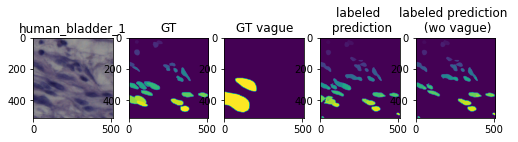

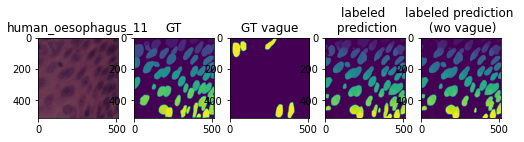

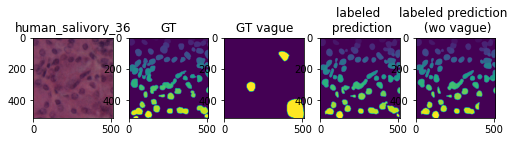

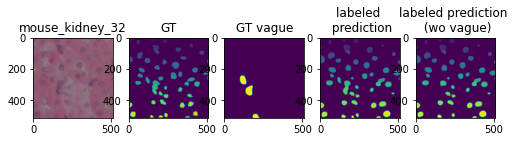

In [ ]:
#showing random images and results from the last fold
for i in range(4):
    rand_num  = np.random.randint(len(validation_set_img))
    plt.figure(figsize= (10,60))
    plt.subplot(1,6,1)
    plt.imshow(validation_set_img[rand_num])
    plt.title(get_id_from_file_path(test_img[rand_num], '.png'))


    plt.subplot(1,6,2)
    plt.imshow(validation_set_label[rand_num])
    plt.title('GT')

    plt.subplot(1,6,3)
    plt.imshow(validation_set_vague[rand_num])
    plt.title('GT vague')

    plt.subplot(1,6,4)
    plt.imshow(output_watershed_tot_fold[rand_num])
    plt.title('labeled \n prediction')

    plt.subplot(1,6,5)
    plt.imshow(output_watershed_tot_fold_wo_vague[rand_num])
    plt.title('labeled prediction \n (wo vague)')

#     plt.subplot(1,6,6)
#     plt.imshow(validation_set_label_tot_fold_wo_vague[rand_num])
#     plt.title('GT wo vague')